# Set up the loss tracking API

In [ ]:
!pip install -q --upgrade wandb==0.10.8
import wandb
wandb.init(project="OriginalUnet",name="FINAL-1")

     |████████████████████████████████| 1.7MB 5.1MB/s 
     |████████████████████████████████| 102kB 10.0MB/s 
     |████████████████████████████████| 81kB 9.1MB/s 
     |████████████████████████████████| 163kB 16.8MB/s 
     |████████████████████████████████| 133kB 17.3MB/s 
     |████████████████████████████████| 71kB 8.4MB/s 


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: wandb version 0.10.29 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


# Import Necessary Libraries

In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import os
from PIL import Image
from tqdm import tqdm_notebook
import random
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
import h5py
from IPython.display import clear_output
from math import floor
from torchsummary import summary
import copy
import seaborn as sns
from pathlib import Path

cuda


# Inpainting and Dataset Functions

In [ ]:
img_width=256
wb_size=16
white_box = torch.ones(wb_size,wb_size)
center = img_width//3
# center=
def randomMask(image): #the random mask is still bounded 
    # white_box = np.array([255]*size*size).reshape(size,size)
    x, y = np.random.randint(center,img_width-wb_size-center, size=2) #42 in so that the image is placed on the middle third 
    image[0,x:x+wb_size, y:y+wb_size] = white_box
    # mask = torch.zeros((1,img_width,img_width))
    # mask[0,x:x+wb_size, y:y+wb_size] = white_box
    return image#,mask
def centerMask(image):
    x,y = ((128//2)-8),((128//2)-8)
    image[0,x:x+wb_size, y:y+wb_size] = white_box
    return image
def customBatchMask(images,positions):
    for i in range(images.shape[0]):
        x = floor(positions[i][0][0][0])
        y = floor(positions[i][1][0][0])
        images[i,0,x:x+wb_size, y:y+wb_size] = white_box
    return images
def customMask(img,position):
    
    x = position[0]
    y = position[1]
    if x+wb_size>=128:
        x=127-wb_size
    if y+wb_size>=128:
        y=127-wb_size
    img[0,x:x+wb_size, y:y+wb_size] = white_box
    mask = torch.zeros((1,img_width,img_width))
    mask[0,x:x+wb_size, y:y+wb_size] = white_box
    return img, mask
def recon_mask(image):
    x, y = np.random.randint(42,img_width-wb_size-42, size=2) #42 in so that the image is placed on the middle third 
    image[0,x:x+wb_size, y:y+wb_size] = white_box
    return image, (x,y)

In [ ]:
class dataset_h5(torch.utils.data.Dataset):
    def __init__(self, in_file, transform=None):
        super(dataset_h5, self).__init__()
 
        self.file = h5py.File(in_file, 'r')
        self.transform = transform
 
    def __getitem__(self, index):
        x = self.file['X_test'][index]
        p = self.file["X_test"][index]
        # Preprocessing each image
        if self.transform is not None:
            x = self.transform(x)   
            p = self.transform(p)     
            p = randomMask(p)
        return x,p#,mask #x is original and p is inpainted
 
    def __len__(self):
        return self.file['X_test'].shape[0]

img_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])
train_set = dataset_h5("/content/drive/MyDrive/datasets/2d_data/NFBS_h5_2D_256/data.h5",transform=img_transform)
Path("outputs/").mkdir(parents=True, exist_ok=True) #generate path to save produced images

# dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,drop_last=False, shuffle=True, num_workers=1)

In [ ]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x
num_workers = 1
batch_size = 8
dataloader = DataLoader(train_set, batch_size=batch_size,drop_last=False, shuffle=True, num_workers=num_workers)
n_channels = 1

# Architecture of Inpainting Network and Discriminator

In [ ]:
# define unet model
class UNet(nn.Module):
  
    def __init__(self, in_class=1, out_class=1,f=64):
        super().__init__()
                
        self.dconv_down1 = self.conv_block(in_class, f)
        self.dconv_down2 = self.conv_block(f, f*2)
        self.dconv_down3 = self.conv_block(f*2, f*4)
        self.dconv_down4 = self.conv_block(f*4, f*8)
        self.dconv_down5 = self.conv_block(512, 1024)

        self.dconv_up4 = self.conv_block(512 + 1024, 512)
        self.dconv_up3 = self.conv_block(f*4 + f*8, f*4)
        self.dconv_up2 = self.conv_block(f*2 + f*4, f*2)
        self.dconv_up1 = self.conv_block(f*2 + f, f)
        
        self.conv_last = nn.Conv2d(f, out_class, 1)
        
    def conv_block(self, in_channels, out_channels,mid=None):
        if mid==None:
            mid=out_channels
        else:
            mid=in_channels//2
        return nn.Sequential(
        nn.Conv2d(in_channels, mid, 3, padding=1),
        nn.BatchNorm2d(mid),
        nn.ReLU(inplace=True),
        nn.Conv2d(mid, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )   
        
    def forward(self, x):
        conv1 = self.dconv_down1(x) # skip-connection 1
        x = F.max_pool2d(conv1, 2)
        conv2 = self.dconv_down2(x) # skip-connection 2
        x = F.max_pool2d(conv2, 2)
        conv3 = self.dconv_down3(x) # skip-connection 3
        x = F.max_pool2d(conv3, 2)

        conv4 = self.dconv_down4(x) # skip-connection 4
        x = F.max_pool2d(conv4, 2)

        x = self.dconv_down5(x) # skip-connection 4
        x = F.interpolate(x, scale_factor=2, mode='bilinear')
        
        x = torch.cat([x, conv4], dim=1)
        x = self.dconv_up4(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear')

        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)
        out = self.conv_last(x)
        
        return out

N = UNet().to(device)
print(f'> Number of network parameters {len(torch.nn.utils.parameters_to_vector(N.parameters()))}')

> Number of network parameters 31389569


In [ ]:
summary(N,(1,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
            Conv2d-7        [-1, 128, 128, 128]          73,856
       BatchNorm2d-8        [-1, 128, 128, 128]             256
              ReLU-9        [-1, 128, 128, 128]               0
           Conv2d-10        [-1, 128, 128, 128]         147,584
      BatchNorm2d-11        [-1, 128, 128, 128]             256
             ReLU-12        [-1, 128, 128, 128]               0
           Conv2d-13          [-1, 256, 64, 64]         295,168
      BatchNorm2d-14          [-1, 256,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self,f=64):
        super(Discriminator, self).__init__()
        self.discriminate = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(1, f,3,2,padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv2d(f, f*2,3,2,padding=1)),
            # nn.MaxPool2d(2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(f*2),
            nn.utils.spectral_norm(nn.Conv2d(f*2, f*4,3,2,padding=1)),
            # nn.MaxPool2d(2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(f*4),
            nn.utils.spectral_norm(nn.Conv2d(f*4, f*8,3,2,padding=1)),
            # nn.MaxPool2d(2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(f*8),
            nn.utils.spectral_norm(nn.Conv2d(f*8, 1,3,2,padding=1)),
            nn.Sigmoid()
                     )
D = Discriminator().to(device)
lossBCE = nn.BCELoss()
# summary(D.discriminate,(1,256,192))

# Training of Inpainting Network

In [ ]:
train_iterator = cycle(dataloader)
# wb_optimiser = torch.optim.Adam(wb_gen.parameters(), lr=0.001)
optimiser_D = torch.optim.Adam(D.parameters(), lr=0.001)#, betas=(0.5, 0.999))
optimiser_G = torch.optim.Adam(N.parameters(), lr=0.0001)
gen_lambda = 50
# G_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser_G, mode='min', factor=0.1, threshold=0.0001, patience=5)
# D_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser_D, mode='min', factor=0.1, threshold=0.0001, patience=5)
step=0
lossL1 = nn.L1Loss()

In [ ]:
# training loop, feel free to also train on the test dataset if you like
while (step<500):
    
    # arrays for metrics
    train_loss_arr = np.zeros(0)
    dis_loss_arr = np.zeros(0)
    # iterate over some of the train dateset
    for i in range(50):

        
        #TRAIN DISCRIMINATOR
        # for _ in range(3):
        x,p= next(train_iterator) #the original and the inpainted one
        x = x.to(device)
        p = p.to(device)
        g = N(p).to(device)
        optimiser_D.zero_grad()

        l_r = lossBCE(D.discriminate(x).mean(), torch.ones(1)[0].to(device)) # real -> 1
        l_f = lossBCE(D.discriminate(g).mean(), torch.zeros(1)[0].to(device)) #  fake -> 0
        loss_d = (l_r + l_f)/2.0
        loss_d.backward()
        optimiser_D.step()
        

        #TRAIN GENERATOR 
        x,p,_ = next(train_iterator) #the original and the inpainted one
        x = x.to(device)
        p = p.to(device)
        g = N(p).to(device)
        optimiser_G.zero_grad()
        gen_loss = lossL1(g,x)*gen_lambda + lossBCE(D.discriminate(g).mean(), torch.ones(1)[0].to(device))
        gen_loss.backward()
        optimiser_G.step()

        #ADD THE LOSSES TO ARRAY
        dis_loss_arr = np.append(dis_loss_arr, loss_d.item())
        train_loss_arr = np.append(train_loss_arr, gen_loss.item())


    wandb.log({ 'UNET Loss':train_loss_arr.mean(),'discriminator loss': dis_loss_arr.mean()})

    imglist = []
    for j in range(5):
        imglist.extend([x[j],p[j],g[j]])
    plt.figure(figsize = (30,30))
    im = torchvision.utils.make_grid(imglist,nrow=3).cpu().data.permute(0,2,1).contiguous().permute(2,1,0)
    im = plt.imshow(torchvision.utils.make_grid(imglist,nrow=3).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    name ="outputs/epoch"+"_"+str(step)+".png"
    plt.savefig(name)
    wandb.save(name)
    step += 1


In [ ]:
#save model to reuse for reconstruction
def save_models_wandb():
    Path("model_weights/").mkdir(parents=True, exist_ok=True) #generate path to save produced images

    torch.save(N,"model_weights/unet32.h5")
    torch.save(D,"model_weights/discriminator32.h5")
    wandb.save("model_weights/unet32.h5")
    wandb.save("model_weights/discriminator32.h5")
save_models_wandb()

In [ ]:
run_path = ("ccm/OriginalUnet/3cdy2b9r")
# def restore_models(run_path):
net = wandb.restore('model_weights/unet16.h5',run_path=run_path)
disc = wandb.restore('model_weights/discriminator16.h5',run_path=run_path)
N = torch.load(net.name).to(device)
D = torch.load(disc.name).to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


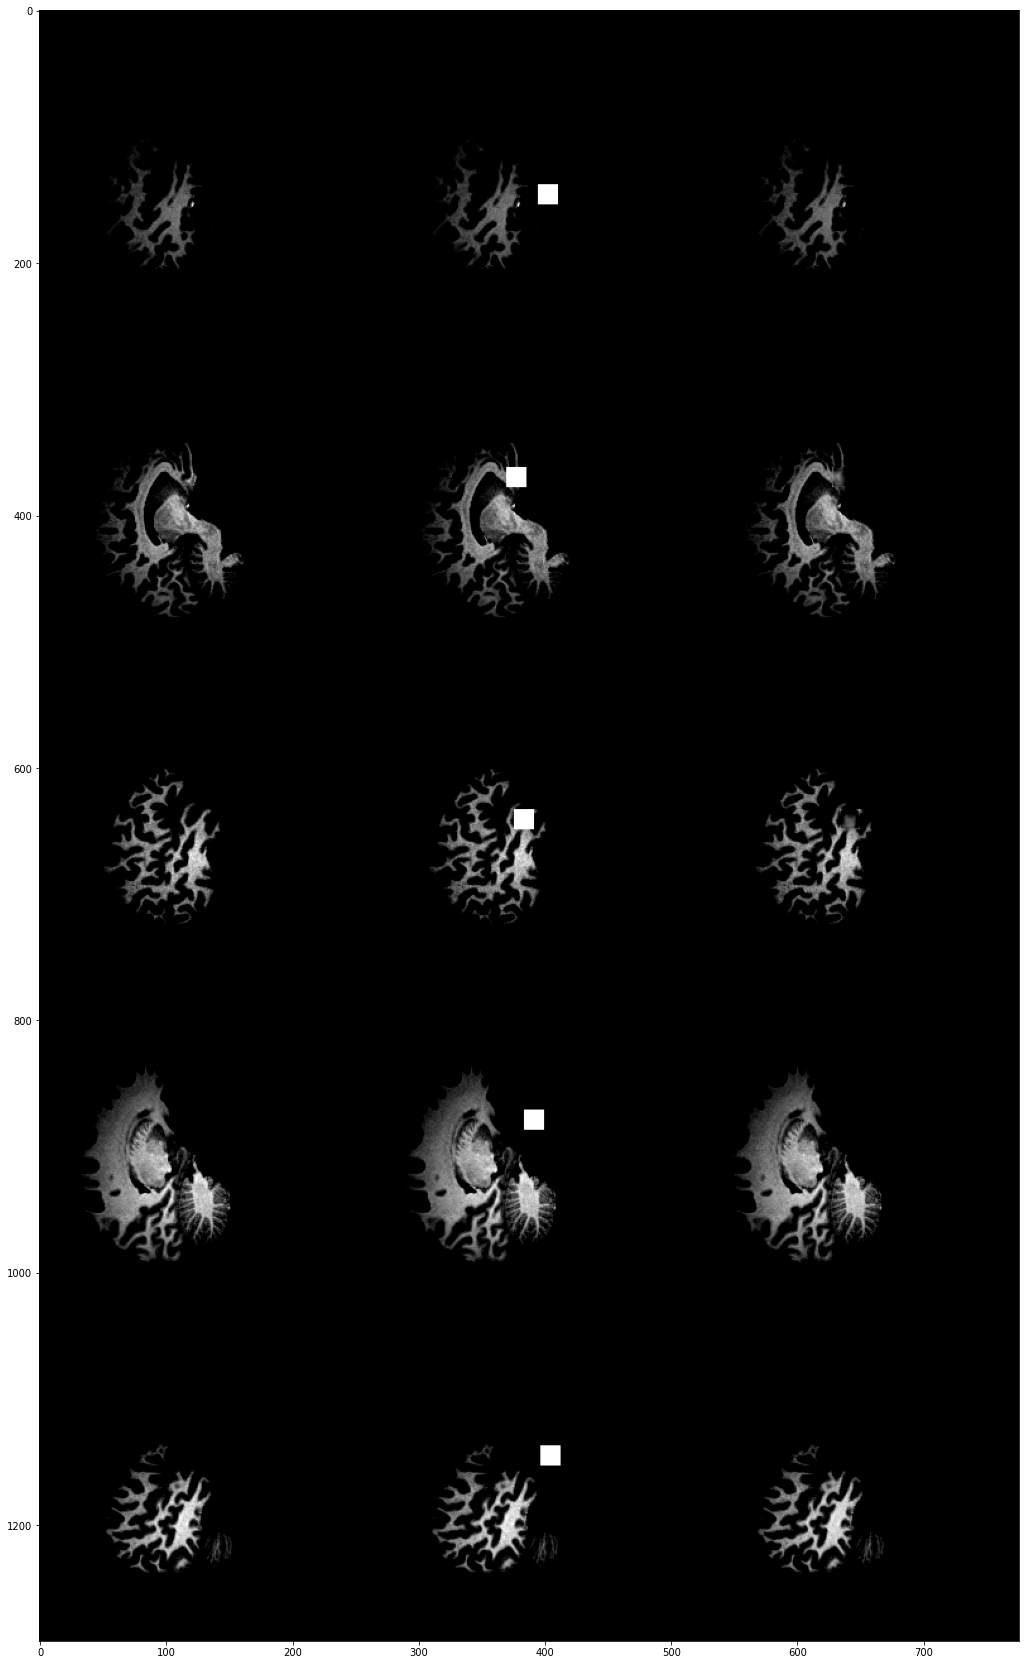

In [ ]:
x,p = next(train_iterator) #the original and the inpainted one
x = x.to(device)
p = p.to(device)
g = N(p).to(device)
imglist = []
for j in range(5):
    imglist.extend([x[j],p[j],g[j]])
plt.figure(figsize = (30,30))
# im = torchvision.utils.make_grid(imglist,nrow=3).cpu().data.permute(0,2,1).contiguous().permute(2,1,0)
im = plt.imshow(torchvision.utils.make_grid(imglist,nrow=3).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)